# Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

### Exploring the neighborhoods of Brooklyn based on venues and rent

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

You find yourself in a postion that you have to move to a neighbourhood in **Brooklyn,NY** but since you are not a native of 
**New York** you don't have a slightest idea of which neighbourhood you should to move to.This report tackles with the simple 
idea of choosing the best neighbourhood for you depending on your budget and taking in the factor of availability of resources 
around the neighbourhood be it a neighbourhood with delicacies of multiple ethnicities or a one with more accessible to parks 
and leisure activities.<br>

Here we will make anlaysis on multiple neighbourhoods and cluster them to fit for multiple individuals that have different needs and 
criteria's for choosing one.


## Data <a name="data"></a>

The dataset on the **New York** neighborhoods and their corresponding coordinates will be mainly collected from the dataset that
is readily available in the **IBMDeveloperSkillsNetwork** portal.<br>
We will be collecting data mainly from the **Foursquare API** through which we will get insights on the venue available in
the neighbourhoods<br>
we will also be taking in the **average rent market trend** data from the website **Rentcafe** which will further help in narrowing 
down neighbourhoods.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from pandas.io.json import json_normalize
import json
import csv
import urllib.request
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [2]:
!pip install folium
import folium

## Data Collection and Cleaning

Our first step is collect all the necessary data required for our analysis
we download the json file containing the data on all the New York city Boroughs and its neighbourhood with its corresponding coordinates.
we download the file that is already available in the IBMDeveloperSkillsNetwork portal.


In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

we know that the data we require is available in the features key of the json file.We directly load it to a new dataframe with necessary coloums

In [5]:
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

neighborhoods = pd.DataFrame(columns=column_names)


for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

We observe the first 5 entries in the dataset.We observe that it contains information on Boroughs.

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Since we are working with neighbourhoods of Brooklyn only we narrow our 
dataset to only neighbourhoods of Brooklyn

In [7]:
brklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


The below displays the shape i.e the total no. of rows and colomns in the dataset
we have 70 rows and 4 coloums.

In [8]:
brklyn_data.shape

(70, 4)

Using the Foursquare API we now  collect the nearby venues available in the neighborhoods of Brooklyn

In [9]:
CLIENT_ID = '<CLIENT_ID>' 
CLIENT_SECRET = '<CLIENT_SECRET>' 
VERSION = '20180605' 
LIMIT = 100 
radius = 500




We now define a function named getNearbyVenues() which when called with its necessary parameters gives us the venues loacted within 0.5kms of 
each neighbourhood

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
brklyn_venues = getNearbyVenues(names=brklyn_data['Neighborhood'],
                                   latitudes=brklyn_data['Latitude'],
                                   longitudes=brklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


Below shows the first 5 entries of the neighbourhoods in Brooklyn

In [12]:
brklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


Since data might not to be available to us in csv format everytime.In these scenarios we have to extract data from the url directly.
Using the python library **beautifulsoup** we can easily extract any tables into csv format from the url
Although they may not be in the perfect format so data cleaning is always necessary with it


We now collect average rent data for neighbourhoods in Brooklyn.
we parse the html page of the website using beautifulsoup libray availabe in python and store the data we collected in a new csv file

In [13]:
url= 'https://www.rentcafe.com/average-rent-market-trends/us/ny/brooklyn/'

In [14]:
response = requests.get(url)
print(response.status_code)
soup = BeautifulSoup(response.text,"html.parser")
table = soup.findAll('table',{"class":"market-trends market-trends-nhood"})[0]
tr = table.findAll(['tr'])[0:52]
csvFile = open("rent.csv",'wt',newline='', encoding='utf-8')
writer = csv.writer(csvFile)  
try:   
        for cell in tr:
            th = cell.find_all('th')
            th_data = [col.text.strip('\n') for col in th]
            td = cell.find_all('td')
            row = [i.text.replace('\n','') for i in td]
            writer.writerow(th_data+row)      
        
finally:   
    csvFile.close()

200


Checking the first 5 entries of the table we find that there are redundant characters in the Average Rent column.so we have to do a bit of cleaning of the data set before
proceeding.


In [15]:
df_brklynrent = pd.read_csv('rent.csv')
df_brklynrent.head()

,Neighborhood,Average Rent
0,Carroll Gardens,"$3,839"
1,Red Hook,"$3,839"
2,Greenpoint,"$3,603"
3,Williamsburg,"$3,304"
4,Brooklyn Navy Yard,"$3,204"


We check for missing neighbourhood entries in the Average rent dataset.After comparing it to our neighborhood dataset we find that many neighbourhoods are
missing from the Average Rent dataset.


In [16]:
df_brklynrent['Neighborhood'] =df_brklynrent['Neighborhood'].replace(['DUMBO'],'Dumbo')

In [17]:
df_not = brklyn_data[~(brklyn_data['Neighborhood'].isin(df_brklynrent['Neighborhood']))]

In [18]:
df_not

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
2,Brooklyn,Sunset Park,40.645103,-74.010316
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438
14,Brooklyn,Brownsville,40.663950,-73.910235
17,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785
25,Brooklyn,Cypress Hills,40.682391,-73.876616
26,Brooklyn,East New York,40.669926,-73.880699
27,Brooklyn,Starrett City,40.647589,-73.879370
30,Brooklyn,Mill Island,40.606336,-73.908186
32,Brooklyn,Coney Island,40.574293,-73.988683


Cleaning the average rent column and removing the redundant characters and changing the data type to float of the values in the column.

In [19]:
for i in df_brklynrent['Average Rent']:
    df_brklynrent['Average Rent'] = df_brklynrent['Average Rent'].replace([i],i.replace('$',''))
    

In [20]:
for i in df_brklynrent['Average Rent']:
    df_brklynrent['Average Rent'] = df_brklynrent['Average Rent'].replace([i],i.replace(',',''))

In [21]:
df_brklynrent.head()

,Neighborhood,Average Rent
0,Carroll Gardens,3839
1,Red Hook,3839
2,Greenpoint,3603
3,Williamsburg,3304
4,Brooklyn Navy Yard,3204


In [22]:
df_brklynrent =df_brklynrent.astype({'Average Rent':'float32'})

In [23]:
df_brklynrent['Average Rent'].describe()

count      51.000000
mean     2434.313721
std       604.762817
min      1734.000000
25%      1898.000000
50%      2200.000000
75%      2952.000000
max      3839.000000
Name: Average Rent, dtype: float64

we now take the mean value of the average rent column and assume it as the rent of the missing neighborhoods and merge it with the rent datasets

In [24]:
df_not['Average Rent'] =df_brklynrent['Average Rent'].mean()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [25]:
df_not.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rent
0,Brooklyn,Bay Ridge,40.625801,-74.030621,2434.313721
2,Brooklyn,Sunset Park,40.645103,-74.010316,2434.313721
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,2434.313721
14,Brooklyn,Brownsville,40.663950,-73.910235,2434.313721
17,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,2434.313721


In [26]:
df_not[['Neighborhood','Average Rent']].head()

,Neighborhood,Average Rent
0,Bay Ridge,2434.313721
2,Sunset Park,2434.313721
7,Manhattan Terrace,2434.313721
14,Brownsville,2434.313721
17,Bedford Stuyvesant,2434.313721


In [27]:
df_brklynrent =df_brklynrent.append(df_not[['Neighborhood','Average Rent']])

In [28]:
df_brklynrent.shape

(81, 2)

In [29]:
df_brklynrent.head()

,Neighborhood,Average Rent
0,Carroll Gardens,3839.0
1,Red Hook,3839.0
2,Greenpoint,3603.0
3,Williamsburg,3304.0
4,Brooklyn Navy Yard,3204.0


## Methodology <a name="methodology"></a>

This project aims in identifying the best neighbourhood suitable for a individual in **Brooklyn,NY**.It takes in the factor of average rent of each neighbourhood and venues available around a radius of 0.5kms
First step includes **collecting data**,which we do by collecting the **NY Borough Dataset** from **IBMDeveloperSkillsNetwork** portal.we select only the required neighbourhood i.e **Brooklyn** in our case and extract the features.We use this dataset to find all the nearby venues around 0.5kms radius.we also extract average market trends from the website for us to group the neighbourhoods in a more informed way.
The next step includes **cleaning of data** by checking the required datatype of the values in the dataset and unwanted extra characters and check for missing values.
The thrid step is where we do **Analysis** on our data.We use K-means clustering to group the neighborhood based on venues near it and its average rent.Based on the analysis we label the clusters on their pattern and plot it in a map with different colored markers for each cluster.

The last step is to **discuss our findings** from the anaylisis and suggest the best neighborhood according to the individuals needs.

## Analysis <a name="analysis"></a>

We now plot the coordinates of the different neighborhoods in Brooklyn with circlemarkers at the correspnding locations.
To do this we make use of the folium library in python.we first require the coordinate of Brooklyn itself which i have found out using 
google.We can also make use of geopy library for this purpose but currently it has some issues and is not working


In [30]:
brok_lat =40.6782
brok_long = -73.9442
brklyn_data =brklyn_data.sort_values(by='Neighborhood').reset_index(drop=True)
df_brklynrent =df_brklynrent.sort_values(by='Neighborhood').reset_index(drop=True)

In [31]:

brok_map = folium.Map(location=[brok_lat, brok_long], zoom_start=12)


for lat, lng, label,label2 in zip(brklyn_data['Latitude'], brklyn_data['Longitude'], brklyn_data['Neighborhood'],df_brklynrent['Average Rent']):
    label = folium.Popup(label+'\n'+str(round(label2)), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup =label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(brok_map)  
    


Below we can see the map of Brooklyn,NY with markers on the each neighborhood.Clicking on the markers we can see its name and the average rent in the neighborhood

In [33]:
brok_map

Below is the pictorial depiction(a barplot) of the average rent dataset.
we can observe that **Carroll Gardens** has the highest amount of 
average rent which is something to consider for 
while choosing a neighborhood.

we also plot a new table checking the total number of venues at each neighbourhood,which gives us an insight on how popular a 
neighborhood is and hence an idea on how easily resources are available nearby

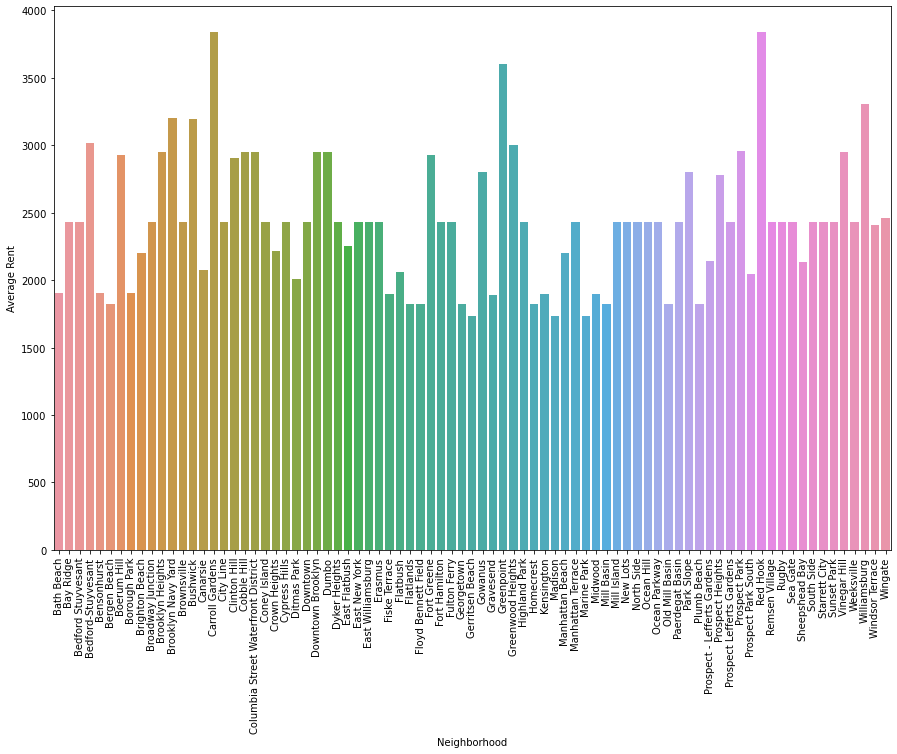

In [34]:
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)
brok_rentbar =sns.barplot(x ='Neighborhood',y = 'Average Rent',ax=ax,data =df_brklynrent)
brok_rentbar.set_xticklabels(brok_rentbar.get_xticklabels(), fontsize=10)
for item in brok_rentbar.get_xticklabels():
    item.set_rotation(90)


In [35]:
brklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,44,44,44,44,44,44
Bay Ridge,80,80,80,80,80,80
Bedford Stuyvesant,28,28,28,28,28,28
Bensonhurst,28,28,28,28,28,28
Bergen Beach,7,7,7,7,7,7
...,...,...,...,...,...,...
Vinegar Hill,28,28,28,28,28,28
Weeksville,14,14,14,14,14,14
Williamsburg,34,34,34,34,34,34


We make a new dataframe by one hot encoding the **Foursquare data** on its neighbourhood venue's .After that we use pandas groupby method to find the mean of the 
one hot encoded venues 

In [32]:

brok_onehot = pd.get_dummies(brklyn_venues[['Venue Category']], prefix="", prefix_sep="")
brok_onehot.drop('Neighborhood', axis=1, inplace=True)
brok_onehot.insert(0,'Neighborhood',brklyn_venues['Neighborhood'])
brok_onehot.head()


,Neighborhood,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
brok_grouped =brok_onehot.groupby('Neighborhood').mean().reset_index()
brok_grouped

,Neighborhood,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bath Beach,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.022727,0.022727,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,Bay Ridge,0.0,0.0,0.0,0.037500,0.000000,0.0,0.0,0.000000,0.012500,...,0.012500,0.000000,0.0125,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,Bedford Stuyvesant,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0,0.000000,0.035714,0.035714,0.0,0.0,0.000000
3,Bensonhurst,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,Bergen Beach,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Vinegar Hill,0.0,0.0,0.0,0.035714,0.035714,0.0,0.0,0.071429,0.000000,...,0.000000,0.000000,0.0000,0.0,0.035714,0.035714,0.035714,0.0,0.0,0.000000
66,Weeksville,0.0,0.0,0.0,0.071429,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
67,Williamsburg,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.029412,0.000000,...,0.000000,0.000000,0.0000,0.0,0.000000,0.029412,0.000000,0.0,0.0,0.029412
68,Windsor Terrace,0.0,0.0,0.0,0.038462,0.038462,0.0,0.0,0.000000,0.038462,...,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.038462,0.0,0.0,0.000000


we now use the above one hot encoded dataset to make a function that returns top ten venues of each neighborhood.By doing this its makes us easier to identify the 
neighbourrhood features and make decisons for the individual

In [40]:
def return_most_common_venues(row, num_top_ten):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_ten]

In [41]:
num_top_ten =10
indicators =['st','nd','rd']
columns =['Neighborhood']
for inp in np.arange(num_top_ten):
    try:
        columns.append('{}{} Most Common Venue'.format(inp+1, indicators[inp]))
    except:
        columns.append('{}th Most Common Venue'.format(inp+1))

brok_venue_sorted = pd.DataFrame(columns=columns)
brok_venue_sorted['Neighborhood'] = brok_grouped['Neighborhood']

for ind in np.arange(brok_grouped.shape[0]):
    brok_venue_sorted.iloc[ind, 1:] = return_most_common_venues(brok_grouped.iloc[ind, :], num_top_ten)

brok_venue_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Peruvian Restaurant,Pizza Place,Donut Shop,Bubble Tea Shop,Italian Restaurant,Chinese Restaurant,Gas Station,Fast Food Restaurant,Ice Cream Shop
1,Bay Ridge,Pizza Place,Spa,Italian Restaurant,Bagel Shop,American Restaurant,Greek Restaurant,Bar,Hookah Bar,Sushi Restaurant,Sandwich Place
2,Bedford Stuyvesant,Coffee Shop,Deli / Bodega,Bar,Café,Pizza Place,Fried Chicken Joint,Gift Shop,Thrift / Vintage Store,Juice Bar,Gourmet Shop
3,Bensonhurst,Italian Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Donut Shop,Butcher,Liquor Store,Noodle House,Supermarket,Shabu-Shabu Restaurant
4,Bergen Beach,Harbor / Marina,Baseball Field,Athletics & Sports,Park,Rental Service,Playground,Factory,Falafel Restaurant,Farm,Farmers Market


Before proceeding with k-means clustering we need to decide an optimal value for K.We do this is implementing **Elbow Method**.
To determine the optimal 'K' we determine the squared error for a range of values for k(range for us is 1 to 11) and plot it on the y axis.
on the x axis we plot the values of 'k'.
From the graph we choose the elbow point for the graph i.e the point after which the mean squared errors start decresing in a linear fashion.
For us its seems K=4 seems to be optimal.

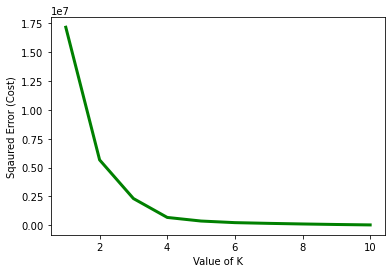

In [42]:
brok_grouped_clustering =brok_grouped.drop('Neighborhood',1)
brok_grouped_clustering.insert(0,'Average Rent',df_brklynrent['Average Rent'])
cost =[] 
#elbow method for determining k
for i in range(1,11):
    KM = KMeans(n_clusters = i,random_state=0) 
    KM.fit(brok_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()


After finding the optimal K i.e 4 for us we use kmeans clustering which will divide/group the dataset into 4 clusters based on similarity.we can use use the cluster labels 
and merge it with one hot encoded dataset.

In [43]:
k = 4
kmean =KMeans(n_clusters = k,random_state=3).fit(brok_grouped_clustering)
kmean.labels_

array([0, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 1, 2, 1, 0, 3, 2, 1, 1, 1, 2, 2,
       2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 3,
       1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2,
       1, 0, 3, 2], dtype=int32)

In [44]:
brok_venue_sorted.insert(0,'Cluster Labels',kmean.labels_)

In [45]:
brok_venue_sorted.insert(2,'Average Rent',df_brklynrent['Average Rent'])

In [48]:
brklyn_merged =brklyn_data
brklyn_merged = brklyn_merged.join(brok_venue_sorted.set_index('Neighborhood'),on='Neighborhood')
brklyn_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bath Beach,40.599519,-73.998752,0,1906.000000,Pharmacy,Peruvian Restaurant,Pizza Place,Donut Shop,Bubble Tea Shop,Italian Restaurant,Chinese Restaurant,Gas Station,Fast Food Restaurant,Ice Cream Shop
1,Brooklyn,Bay Ridge,40.625801,-74.030621,2,2434.313721,Pizza Place,Spa,Italian Restaurant,Bagel Shop,American Restaurant,Greek Restaurant,Bar,Hookah Bar,Sushi Restaurant,Sandwich Place
2,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,2,2434.313721,Coffee Shop,Deli / Bodega,Bar,Café,Pizza Place,Fried Chicken Joint,Gift Shop,Thrift / Vintage Store,Juice Bar,Gourmet Shop
3,Brooklyn,Bensonhurst,40.611009,-73.995180,1,3016.000000,Italian Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Donut Shop,Butcher,Liquor Store,Noodle House,Supermarket,Shabu-Shabu Restaurant
4,Brooklyn,Bergen Beach,40.615150,-73.898556,0,1906.000000,Harbor / Marina,Baseball Field,Athletics & Sports,Park,Rental Service,Playground,Factory,Falafel Restaurant,Farm,Farmers Market


In [49]:
decimals = 2    
brklyn_merged['Average Rent'] = brklyn_merged['Average Rent'].apply(lambda x: round(x, decimals))

Below are the clustered neighbourhoods that are grouped into 4 plotted in the map of **Brooklyn**.
We use different colors for each cluster to make it more distinguishable 

In [50]:
map_clusters = folium.Map(location=[brok_lat, brok_long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,avgrent in zip(brklyn_merged['Latitude'], brklyn_merged['Longitude'], brklyn_merged['Neighborhood'], brklyn_merged['Cluster Labels'],brklyn_merged['Average Rent']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+'\nAverage Rent:$'+str(avgrent), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the map we can observe that most of the cheaper rent neighborhoods are further away from the center

Below we get the list of all clustered neighbohood grouped together

### Cluster 0

In [51]:
brklyn_merged.loc[brklyn_merged['Cluster Labels'] == 0, brklyn_merged.columns[[1] + list(range(4, brklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,0,1906.0,Pharmacy,Peruvian Restaurant,Pizza Place,Donut Shop,Bubble Tea Shop,Italian Restaurant,Chinese Restaurant,Gas Station,Fast Food Restaurant,Ice Cream Shop
4,Bergen Beach,0,1906.0,Harbor / Marina,Baseball Field,Athletics & Sports,Park,Rental Service,Playground,Factory,Falafel Restaurant,Farm,Farmers Market
5,Boerum Hill,0,1824.0,Coffee Shop,Dance Studio,Bar,Furniture / Home Store,Sandwich Place,Bakery,Arts & Crafts Store,French Restaurant,Yoga Studio,Middle Eastern Restaurant
7,Brighton Beach,0,1908.0,Restaurant,Eastern European Restaurant,Mobile Phone Shop,Pharmacy,Bank,Russian Restaurant,Gourmet Shop,Beach,Sushi Restaurant,Supplement Shop
14,City Line,0,2077.0,Donut Shop,Grocery Store,Shoe Store,Fried Chicken Joint,Mobile Phone Shop,Ice Cream Shop,Sandwich Place,Chinese Restaurant,Cosmetics Shop,Dance Studio
23,Dyker Heights,0,2008.0,Playground,Burger Joint,Golf Course,Bagel Shop,Arts & Crafts Store,Yoga Studio,Fish & Chips Shop,Farmers Market,Fast Food Restaurant,Field
32,Fulton Ferry,0,1898.0,Park,American Restaurant,Roof Deck,Ice Cream Shop,Pizza Place,Scenic Lookout,Boat or Ferry,Coffee Shop,Playground,Bakery
33,Georgetown,0,2064.0,Bank,Pharmacy,Breakfast Spot,Donut Shop,Mexican Restaurant,Shopping Mall,Supermarket,Frozen Yogurt Shop,Miscellaneous Shop,Burger Joint
34,Gerritsen Beach,0,1824.0,Harbor / Marina,Bar,Ice Cream Shop,Bagel Shop,Pizza Place,Convenience Store,Restaurant,Park,Event Space,Seafood Restaurant
35,Gowanus,0,1824.0,Italian Restaurant,Bar,Furniture / Home Store,Gym / Fitness Center,Chinese Restaurant,Playground,Pizza Place,Deli / Bodega,Coffee Shop,Yoga Studio


### Cluster 1

In [52]:
brklyn_merged.loc[brklyn_merged['Cluster Labels'] == 1, brklyn_merged.columns[[1] + list(range(4, brklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bensonhurst,1,3016.0,Italian Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Donut Shop,Butcher,Liquor Store,Noodle House,Supermarket,Shabu-Shabu Restaurant
6,Borough Park,1,2932.0,Bank,Pizza Place,Fast Food Restaurant,Pharmacy,Hotel,Bakery,Deli / Bodega,Chinese Restaurant,American Restaurant,Grocery Store
10,Brownsville,1,2952.0,Chinese Restaurant,Fried Chicken Joint,Restaurant,Moving Target,Farmers Market,Spanish Restaurant,Trail,Park,Performing Arts Venue,Plaza
11,Bushwick,1,3204.0,Bar,Coffee Shop,Mexican Restaurant,Deli / Bodega,Thrift / Vintage Store,Discount Store,Pharmacy,Taco Place,Vegetarian / Vegan Restaurant,Pizza Place
13,Carroll Gardens,1,3199.0,Italian Restaurant,Coffee Shop,Bakery,Pizza Place,Cocktail Bar,Spa,Wine Shop,Food & Drink Shop,Bar,Grocery Store
17,Coney Island,1,2904.0,Baseball Stadium,Brewery,Athletics & Sports,Monument / Landmark,Music Venue,Skating Rink,Café,Caribbean Restaurant,Beach,Theme Park Ride / Attraction
18,Crown Heights,1,2952.0,Pizza Place,Museum,Café,Bakery,Playground,Coffee Shop,Supermarket,Sushi Restaurant,Candy Store,Liquor Store
19,Cypress Hills,1,2952.0,Latin American Restaurant,Donut Shop,Fried Chicken Joint,Fast Food Restaurant,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Discount Store,Seafood Restaurant,Baseball Field
25,East New York,1,2952.0,Food Truck,Convenience Store,Fried Chicken Joint,Bus Station,Fast Food Restaurant,Caribbean Restaurant,Chinese Restaurant,Event Service,Plaza,Home Service
26,East Williamsburg,1,2952.0,Bar,Deli / Bodega,Cocktail Bar,Bakery,Mexican Restaurant,Concert Hall,Sandwich Place,Café,Donut Shop,Coffee Shop


### Cluster 2

In [53]:
brklyn_merged.loc[brklyn_merged['Cluster Labels'] == 2, brklyn_merged.columns[[1] + list(range(4, brklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bay Ridge,2,2434.31,Pizza Place,Spa,Italian Restaurant,Bagel Shop,American Restaurant,Greek Restaurant,Bar,Hookah Bar,Sushi Restaurant,Sandwich Place
2,Bedford Stuyvesant,2,2434.31,Coffee Shop,Deli / Bodega,Bar,Café,Pizza Place,Fried Chicken Joint,Gift Shop,Thrift / Vintage Store,Juice Bar,Gourmet Shop
8,Broadway Junction,2,2200.00,Hotel,Gas Station,Donut Shop,Ice Cream Shop,Sandwich Place,Breakfast Spot,Fried Chicken Joint,Nightclub,Bus Stop,Caribbean Restaurant
9,Brooklyn Heights,2,2434.31,Deli / Bodega,Yoga Studio,Italian Restaurant,Pizza Place,Coffee Shop,Cosmetics Shop,Park,Gym,Plaza,Pharmacy
12,Canarsie,2,2434.31,Gym,Asian Restaurant,Thai Restaurant,Caribbean Restaurant,Home Service,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
16,Cobble Hill,2,2434.31,Playground,Cocktail Bar,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Italian Restaurant,Yoga Studio,Bar,Bakery,Deli / Bodega
20,Ditmas Park,2,2434.31,Chinese Restaurant,Deli / Bodega,Pizza Place,Caribbean Restaurant,Pharmacy,Department Store,Donut Shop,Kids Store,Salon / Barbershop,Clothing Store
21,Downtown,2,2220.00,Coffee Shop,Burger Joint,Chinese Restaurant,Pizza Place,Sandwich Place,Bar,Furniture / Home Store,Performing Arts Venue,Middle Eastern Restaurant,Spa
22,Dumbo,2,2434.31,Scenic Lookout,Park,Bakery,Boxing Gym,Pizza Place,Italian Restaurant,Gym,Coffee Shop,Café,Yoga Studio
24,East Flatbush,2,2434.31,Chinese Restaurant,Moving Target,Pharmacy,Check Cashing Service,Park,Fast Food Restaurant,Caribbean Restaurant,Liquor Store,Supermarket,Food & Drink Shop


### Cluster 3

In [54]:
brklyn_merged.loc[brklyn_merged['Cluster Labels'] == 3, brklyn_merged.columns[[1] + list(range(4, brklyn_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Average Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Clinton Hill,3,3839.0,Pizza Place,Italian Restaurant,Thai Restaurant,Wine Shop,Restaurant,Mexican Restaurant,Arts & Crafts Store,Yoga Studio,Japanese Restaurant,Indian Restaurant
43,Manhattan Terrace,3,3603.0,Pizza Place,Ice Cream Shop,Donut Shop,Jazz Club,Mobile Phone Shop,Steakhouse,Organic Grocery,Liquor Store,Coffee Shop,Bank
68,Windsor Terrace,3,3839.0,Diner,Park,Plaza,Grocery Store,Butcher,Café,Middle Eastern Restaurant,Bookstore,Chinese Restaurant,Sushi Restaurant


## Results and Discussion <a name="results"></a>

With our clustered neighbourhoods we can now determine the best suited neighbourhood for the individual moving to Brooklyn,NY.
We have gathered data on nearby venues and average  market rent trend in the neghborhood and using that we have clustered the neighborhood 
into 4 clusters.We can now narrow down on the clusters depending on the individuals conditions.
we can label the clusters as the following
#### Cluster 0:
The neighbourhoods in this cluster are have the cheapest rent and mostly has all kinds of restaurants and shop for recreational activities.
#### Cluster 1:
The neighbourhoods in this cluster have rents on the higher end and is filled with diverse and multicultural restaurants.There also seem to be a lot of pubs and bars in most of the neghbourhoods of this cluster.So there a vivid nightlife in this area.
#### Cluster 2:
The neighbourhoods in this cluster have mostly average rent andd is almost similar to cluster 0 in terms of venues.The only differentiator factor here is the rent
#### Cluster 3:
The neighbourhoods in this cluster have highest rent and seems like a posh area.The area has multiple jazz clubs and wine shops

An individual can look up this information and make an informed decision on which area is more well suited for him/her.

## Conclusion <a name="conclusion"></a>

We have finally clustered and completed analysis on the different neighbourhoods of Brooklyn,NY based on nearby venues and rent trends.We have used the clustered coordinates and plotted it over the map of Brooklyn.The purpose of this case was to help the individual in making a informed decision on which neighborhood to choose
